## Word Embedding

### GOAL: use 3 chars to predict the following one

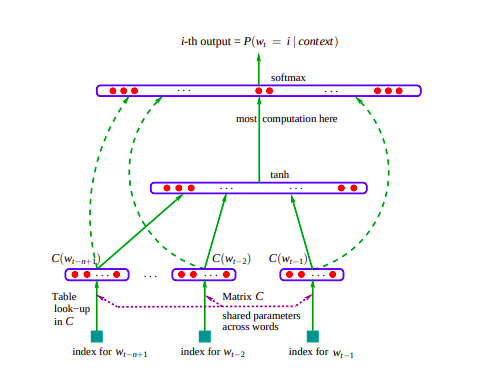

In [71]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [72]:
# 1. create the dataset
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [73]:
# char to integer mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0 

# integer to char mapping
itos = {i:s for s,i in stoi.items()}

In [74]:
BLOCK_SIZE = 3
def build_dataset(words):
    xs = []; ys = []
    for word in words:
        contxt = [0]*BLOCK_SIZE
        for ch in word+".":
            i = stoi[ch]
            xs.append(contxt)
            ys.append(i)
            contxt = contxt[1:] + [i]
    xs = torch.tensor(xs); ys = torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys
        

### build the dataset

In [75]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### what's next
inputs to neural networks cannot be words, so we use what's called `embeddings` which transforms words into numbers  
first layer is just the embeddings  
the input is the raw `x` (string of 3 letters) -> output is the 2 numbers for each letter -> total of 6


what to expect when we do `X @ C`?
> x is for example `27*3` for each row the output is `3*2` ---> total of `27*6`  but then we wanna separate each 2 outputs such that output is 

In [76]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 2), generator=g, requires_grad=True)

In [77]:
# h = F.one_hot(xs, num_classes=27).to(torch.float32) @ C equivalent to C[x]
embeddings = C[Xtr]
embeddings.shape # for each letter in the 32*3 matrix -> the output is 1*2

torch.Size([182625, 3, 2])

In [78]:
HIDDEN_LAYER_SIZE = 100
W1 = torch.randn((6, HIDDEN_LAYER_SIZE), generator=g, requires_grad=True)
b1 = torch.randn(HIDDEN_LAYER_SIZE, generator=g, requires_grad=True)
h =  torch.tanh(embeddings.view((-1, 6)) @ W1 + b1)
# 32 6 @ 6 100 = 32 * 100
# 32 100
# 1  100

In [79]:
W2 = torch.randn((HIDDEN_LAYER_SIZE, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)

# NOTE: You must set requires_grad=True before you compute logits and loss.
params = [C, W1, b1, W2, b2]
    
sum(param.nelement() for param in params)

logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(19.5116, grad_fn=<NllLossBackward0>)

In [80]:
lr = 0.1
# backward pass:
for param in params:
    param.grad = None
loss.backward()

for param in params:
    param.data -= lr * param.grad

In [81]:
loss.item()

19.511638641357422

### what's the appropriate value of the `learning rate`:


```py
# test for different values of learning rate (lr) to find a stable and effective value
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

losses = [];

# putting everything together:
for i in range(100):
    # forward pass:
    embeddings = C[Xtr]
    h =  torch.tanh(embeddings.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    losses.append(loss.item())
    
    # backward pass:
    for param in params:
        param.grad = None
    loss.backward()

    for param in params:
        param.data -= lrs[i] * param.grad
    
plt.plot(lre, losses) # choose the value at the ()
    
# ---- How to choose a good learning rate? ----
# Look for the lowest point on the curve before the loss spikes or becomes unstable.
# A good learning rate is where the loss is low and the curve is still smooth (not exploding).
# Pick a value just before the loss starts to increase or oscillate wildly.
```

In [102]:
# putting everything together:
for i in range(100):
    # forward pass:
    embeddings = C[Xtr]
    h =  torch.tanh(embeddings.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)
    
    # backward pass:
    for param in params:
        param.grad = None
    loss.backward()

    for param in params:
        param.data -= 0.1 * param.grad
    

print(f"loss (training set): {loss.item()}")

loss (training set): 2.5020973682403564


In [99]:
logits.max(1)

torch.return_types.max(
values=tensor([3.6003, 4.7006, 1.4561,  ..., 1.0132, 2.8880, 2.2773],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1,  1,  5,  ...,  9, 14,  0]))

In [100]:
# Evaluate the loss in the dev set
embeddings = C[Xdev]
h =  torch.tanh(embeddings.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f"loss (validation set): {loss.item()}")

loss (validation set): 2.5041568279266357


### sampling from the model

In [101]:
for i in range(20):
    contxt = [0]*BLOCK_SIZE
    outs = []
    while True:
        embedding = C[torch.tensor([contxt])]
        h =  torch.tanh(embedding.view((-1, 6)) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        outs.append(ix)
        contxt = contxt[1:] + [ix]
        if ix == 0: break
    print("".join(itos[i] for i in outs))
    
# these names sound too weird :(

nrec.
ahes.
mlean.
lan.
aolynin.
mer.
jayllsucanno.
balrnn.
guaano.
muanzezei.
miyva.
kealozllzah.
alen.
finsyi.
rafm.
borteomvenas.
jayathan.
kebartorynya.
nai.
cmonn.
